This notebook was made to predict the heights and time for high and low waters in New West, Mission, Sandheads, Steveston, Deas Island by relating them to the corresponding higher high and lower low water at Point Atkinson and discharge at Hope.

In [1]:
from __future__ import division
from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import arrow
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'Steveston Jetty':{
        'lat': 49.1057,
        'lon': -123.3032,
        'i' : 428,
        'j' : 292
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  500,
        'j':367
    },


        }
## location of Steveston from EC is:
#-123.185, 49.1242, so 13km away from
#our location for that in the model 

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    }

In [4]:
grid_TT = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment\
/14days_norefraserxml/16jun15/SalishSea_1h_20150616_20150629_grid_T.nc')

In [5]:
t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_TT)

In [6]:
def zoomin_period_tide(grid_T, stn_name, PST , MSL = 0):
    "Find out tide heights and time in PST or UTC \
     given a time series at stations we got our tidal predictions"
    time_shift = datetime.timedelta(hours=-8)# 8hrs between PST & UTC
    #in winter
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    ssh_zoom = []
    time_zoom = []
    for i in np.arange(len(ttide)):
        if (time[i].year == t_orig.year) & (time[i].month == t_orig.month)\
        & (time[i].day >= t_orig.day) & (time[i].day <= t_end.day):
            ssh_zoom.append(ssh[i])
            time_zoom.append(time[i])
    return ssh_zoom, time_zoom, t_orig, t_end

In [7]:
def find_highlow_tide(grid_T, ssh_zoom, time_zoom, t_end, t_orig, PST ):
    "Determine high and low tide heights in PST or UTC at\
    a given day at stations we got our tidal predictions, unit of \
    return ssh_max, ssh_min is feet rather than meter"
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_max.append(max(ssh_zoom[j:j+24])/0.3048)
        ssh_min.append(min(ssh_zoom[j:j+24])/0.3048)
        time_max.append(time_zoom[ssh_zoom.index(max(ssh_zoom[j:j+24]))])  
        time_min.append(time_zoom[ssh_zoom.index(min(ssh_zoom[j:j+24]))]) 
        j = j +24
    return ssh_max, ssh_min, time_max, time_min

In [8]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_TT,'Point Atkinson', 0, MSL = 0)
## I am not sure if MSL should be 0 or 1, does it really matter the relationship between PA and various
#stns water level...???

In [9]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_TT, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [10]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

# SSH for various stns in model results

In [11]:
ssh_mod = grid_TT.variables['sossheig']
time_mod = grid_TT.variables['time_counter'][:]

In [12]:
t = nc_tools.timestamp(grid_TT, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

In [13]:
def readoff_stn_highlow_waterlevel(t_end, t_orig, jnd, ind, ssh_mod, time_mod):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(time_mod[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(time_mod[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min   

In [14]:
def readoff_stn_highlow_waterlevel_new(t_end, t_orig, jnd, ind, ssh_mod, tt):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(tt[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(tt[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min   

In [15]:
def get_time_lag( ttmin, time_min, ttma, time_max ):
    """This function was made to calculate time lag
        of high and low water level between stns and 
        PA"""
    delta_min = []
    delta_max = []
    for t1, t2, t3, t4 in zip( ttmin, time_min,ttma, time_max):
        diff_min = (t1.hour- t2.hour) * 60 + (t1.minute - t2.minute)
        diff_max = (t3.hour- t4.hour) * 60 + (t3.minute - t4.minute)
        delta_min.append(diff_min)
        delta_max.append(diff_max)
    return delta_max, delta_min

In [48]:
def zoomin_tide_EC(obs):
    """To select the time period of observation 
        water levels from Environment Canada
        need to fix to include all stns!!!"""
    time_shift = datetime.timedelta(hours=8)
    #time = obs['08MH024'][:] + time_shift
    wl_zoom = [] ## water level list for stn
    time_zoom = []
    tt = [] ## final selected time series
    for i in obs['08MH028']:
        if type(i) <> unicode:
            c = i +  time_shift
            time_zoom.append(c) ## translate to UTC time
    for t, j in zip(time_zoom, obs['Unnamed: 1']):
        if (t.day >=16) & (t.day <= 29):
            tt.append(t)
            wl_zoom.append(j)
    return tt, wl_zoom

In [17]:
def find_highlow_tide_EC(tt, wl_zoom):
    """This function was made to determine
        extrema high and low water level
        at Fraser gauges"""
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j=0
    for i in np.arange(tt[-1].day - tt[0].day + 1):
        ssh_max.append(max(wl_zoom[j: j+24])/0.3048)
        ssh_min.append(min(wl_zoom[j: j+24])/0.3048)
        time_max.append(tt[wl_zoom.index(max(wl_zoom[j:j+24]))])
        time_min.append(tt[wl_zoom.index(min(wl_zoom[j:j+24]))])
        j = j + 24
    return ssh_max, ssh_min, time_max, time_min

In [18]:
def zoomin_highlow_FOC(NW):
    """To extract the time and
        water levels from Fisheries & Ocean Canada
    """
    time_shift = datetime.timedelta(hours=8)
    wl_zoom = [] ## water level list for stn
    t = []
    #time_zoom = []
    tt = [] ## final selected time series
    for i in NW['Obs_date']:
        t.append(datetime.datetime.strptime(i,"%Y/%m/%d %H:%M%S"))
    for j, jj in zip(t, NW['SLEV(metres)']):
        c= j - time_shift
        tt.append(c)  ## translate to UTC time
        wl_zoom.append(jj)
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    ii = 0
    for i in np.arange(tt[-1].day - tt[0].day + 1):
        ssh_max.append(max(wl_zoom[ii: ii+24])/0.3048)
        ssh_min.append(min(wl_zoom[ii: ii+24])/0.3048)
        time_max.append(tt[wl_zoom.index(max(wl_zoom[ii:ii+24]))])
        time_min.append(tt[wl_zoom.index(min(wl_zoom[ii:ii+24]))])
        ii = ii + 24
    return ssh_max, ssh_min, time_max, time_min

In [19]:
def print_out_diff_wl(mima, mimi):
    """To print out difference of high and low
        water levels at each Fraser gauge for
        both models and obs from EC
        Input: mima & mimi are high & low water
        levels for stn.
        Output: array of their difference[unit feet]"""
    df = []
    for i, j in zip(mima, mimi):
        d = i -j
        df.append(d)
    return df

In [20]:
def plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, stn):
    """This function was made to plot water level height
    and time lag for Fraser gauges with PA tidal height """
    fig, axs = plt.subplots(1,2, figsize = (20,10))
    axs[0].scatter(ssh_model,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[0].text(-2, 4, r'$Q_Hope = 200,000cfs$', fontsize=15)
    axs[0].grid()
    axs[0].set_xlim([-8, 14])
    axs[0].set_ylim([-10, 6])
    axs[0].set_xlabel('Water level at ' + stn + ' [feet]')
    axs[0].set_ylabel('Point Atkinson Height[feet]')
    axs[1].scatter(time_lag_mod,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[1].grid()
    #ax.set_xlim([4.5, 9.5])
    #ax.set_ylim([-10, 6])
    axs[1].set_xlabel('Time lag at ' + stn + ' [Minute]')
    axs[1].set_ylabel('Point Atkinson Height[feet]')
    return fig

New Westminster

In [21]:
## use another time counts
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 418, 365,ssh_mod, tt)

In [22]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [23]:
df = print_out_diff_wl(tma, tmi)
df

[2.3100437141778905,
 2.4395590535611928,
 2.599081264080338,
 2.756062846171262,
 2.6874783940202605,
 2.6152269264531567,
 2.4718605470782506,
 2.3481977267528142,
 2.1347176684482196,
 1.8775044620193517,
 1.9404319484089925,
 2.0268183993542292,
 2.0595106083577068,
 2.1672389638705516]

In [24]:
## average, max and min of the tidal amplitude at NW
ddf = np.array(df)
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_NW))

Max amplitude of model: 0.84
Min amplitude of model: 0.5723
Mean amplitude of model: 0.7061


In [30]:
delta_max, delta_min = get_time_lag(ttmin, time_min, ttma, time_max)

In [31]:
##combine both time lag for high and low water level at NEW WESTMINSTER
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

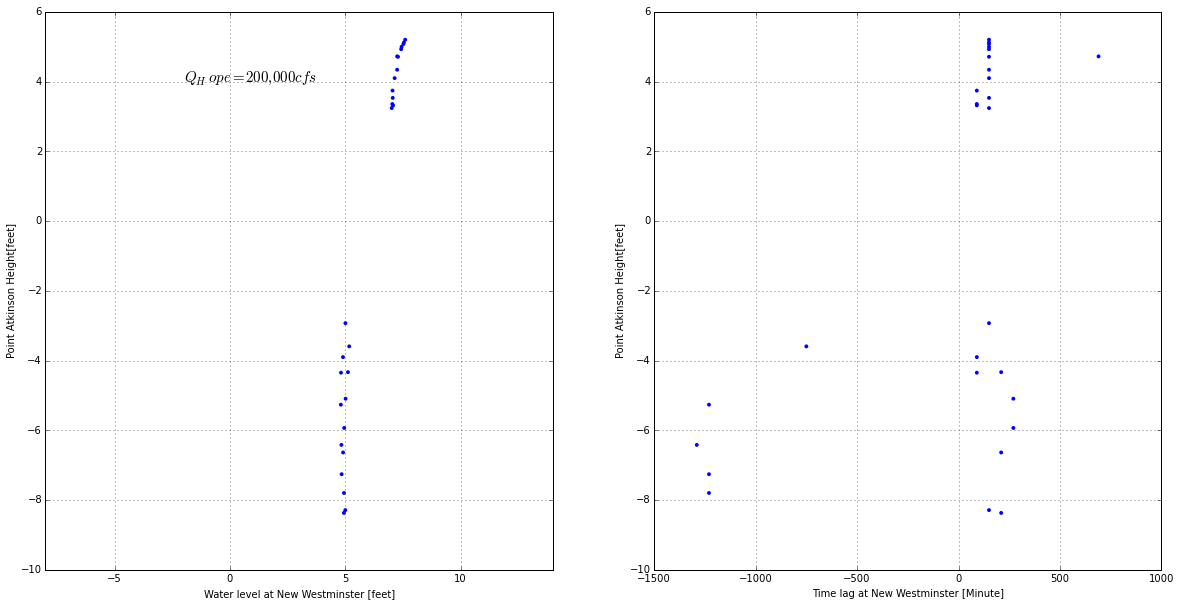

In [25]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'New Westminster')

* The difference of high and low water level(tide amplitude) for New West is 2-2.8 feet(0.85m). Compared with paper's, which is aroudn 4.5 feet(1.3716m)? Difference is 0.5m. Ours is weak, which means the dissipation of tide at New West in our case is too fast and location of NW is too far. I tried to change the grid point of New West more or less, but the tidal amplitude does not vary much. 
* I want to see the amplitude of obs but Ages only provide graph, not exact data, maybe I should find somewhere to get the real data and see how much difference it is. Fisheries & Ocean Canada website: http://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/maps-cartes/inventory-inventaire-eng.asp Comparison of this data with model result is as follows: 

#Load data from Fisheries & Oceans Canada at New Westminster

In [21]:
NW = pd.read_csv('7654-16-JUN-2015_slev.csv',skiprows=7,index_col=False)

In [63]:
FOC_max, FOC_min, FOC_tmax, FOC_tmin = zoomin_highlow_FOC(NW)

In [64]:
##combine both max and min water level for NW with FOC obs
ssh_obs_FOC = []
ssh_obs_FOC.append(FOC_max[0:14])
ssh_obs_FOC.append(FOC_min[0:14])

In [65]:
df = print_out_diff_wl(FOC_max, FOC_min)
df

[6.9225721784776901,
 7.3490813648293951,
 7.3818897637795278,
 7.4803149606299213,
 7.2834645669291334,
 6.6929133858267704,
 6.3320209973753272,
 5.4790026246719137,
 4.790026246719159,
 4.6916010498687664,
 5.2821522309711284,
 5.6758530183727025,
 5.9055118110236204,
 6.2992125984251972,
 0.0]

In [66]:
## average, max and min of the tidal amplitude at NW for observation
ddf = np.array(df[:-1])
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of observation: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of observation: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of observation: {0:.4}'.format(mean_ddf_NW))

Max amplitude of observation: 2.28
Min amplitude of observation: 1.43
Mean amplitude of observation: 1.906


In [123]:
delta_max_obs, delta_min_obs = get_time_lag(FOC_tmin, time_min, FOC_tmax, time_max)

In [130]:
##combine both time lag for high and low water level at NW with FOC obs
time_lag_obs = []
time_lag_obs.append(delta_max_obs)
time_lag_obs.append(delta_min_obs)

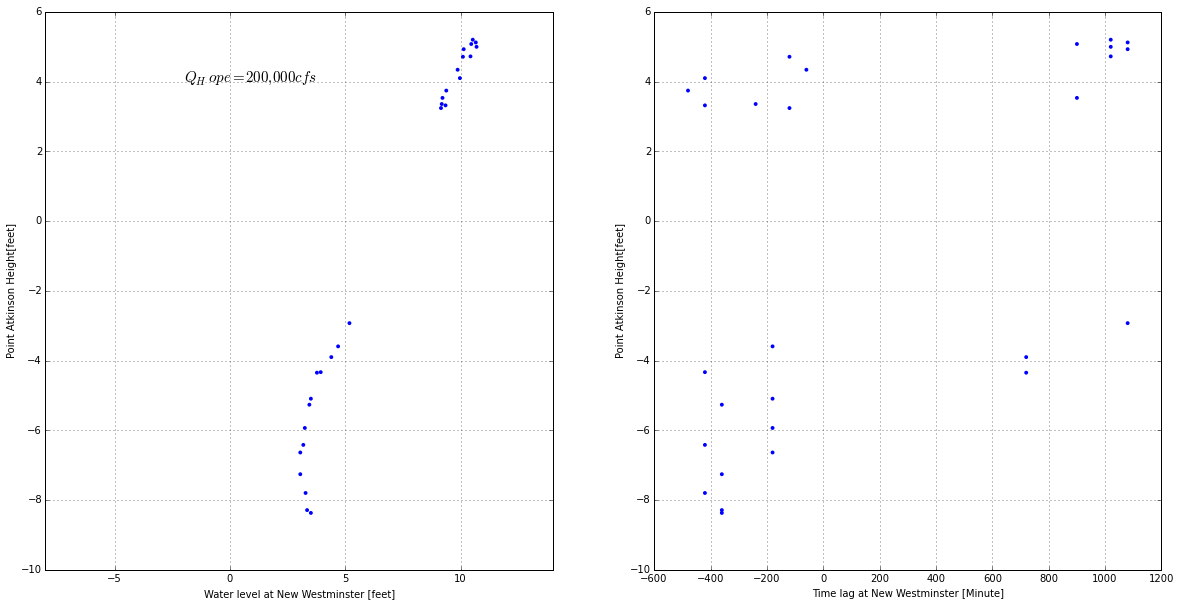

In [149]:
fig = plot_height_time_stn(ssh_obs_FOC, ssh_obs, time_lag_obs, 'New Westminster')

* It is clear to see the amplitude of data ranges from 4-7 feet, while ours is 1-2 feet, dissipates too much, ours is 1-1.5m lower than obs. Need deepen river channel at the beginning more.

Mission

In [57]:
## grid cell for Mission is [500, 367]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 500, 367,ssh_mod, tt)

In [58]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [59]:
df = print_out_diff_wl(mima, mimi)

In [60]:
df

[2.2800505317728037,
 2.5525133753698954,
 2.6381884034224372,
 2.7690006522681774,
 2.6945554678208552,
 2.5566196034899535,
 2.4566457183968051,
 2.3273857716187401,
 2.1067644980322973,
 1.8657411490212583,
 1.9253645669131147,
 2.0164536835327551,
 2.0293856230307759,
 2.1260902481129156]

In [61]:
## average, max and min of the tidal amplitude at Mission
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 0.844
Min amplitude of model: 0.5687
Mean amplitude of model: 0.7042


In [30]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [31]:
##combine both time lag for high and low water level at Mission
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

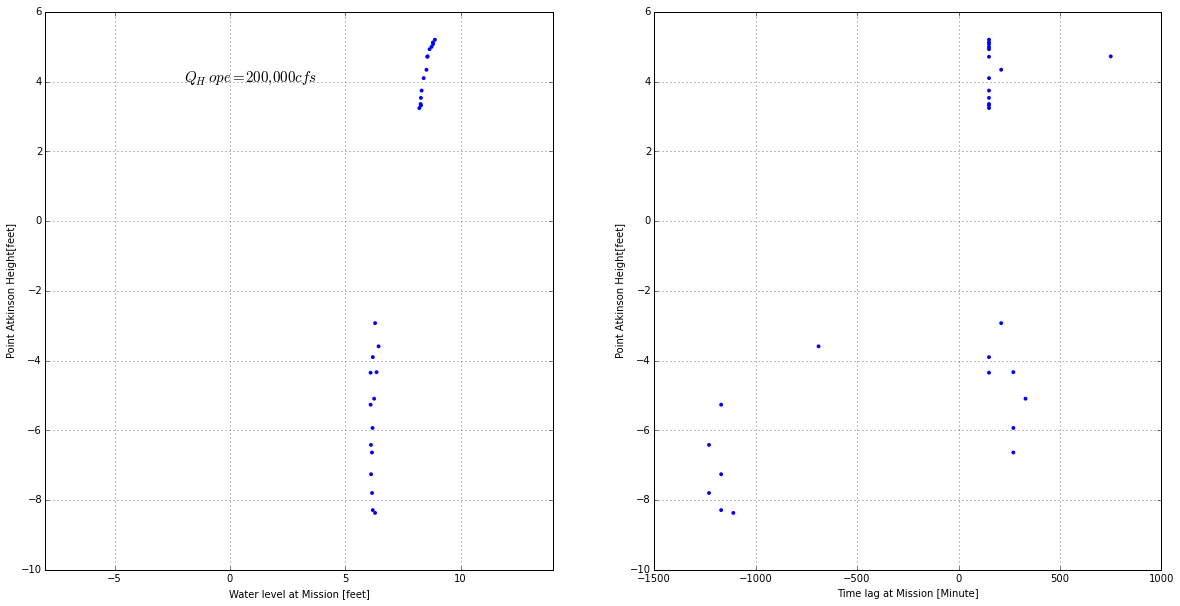

In [32]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Mission')

* Mission in Ages model show vertical line for QHope = 300,000 cfs that are not affected by tide. I will compare it with obs from EC to as follows.

# Compare with EC data

In [25]:
obs = pd.read_excel('08MH024_HRLY_2015.xls', skiprows = 0)

In [27]:
tt, wl_zoom = zoomin_tide_EC(obs)

In [28]:
obs_max, obs_min, t_max, t_min = find_highlow_tide_EC(tt, wl_zoom)

In [29]:
##combine both max and min water level for MISIION with EC obs
ssh_obs_EC = []
ssh_obs_EC.append(obs_max)
ssh_obs_EC.append(obs_min)

In [30]:
df = print_out_diff_wl(obs_max, obs_min)

In [31]:
df

[0.8956692913385833,
 0.78740157480315,
 1.053149606299213,
 0.9744094488188981,
 1.1450131233595808,
 1.2237532808398957,
 1.1286089238845136,
 1.0958005249343827,
 0.9940944881889777,
 0.8300524934383215,
 0.9547244094488185,
 0.9547244094488194,
 0.9678477690288707,
 1.0695538057742793]

In [32]:
## average, max and min of the tidal amplitude at Mission for observation
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of observation: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of observation: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of observation: {0:.4}'.format(mean_ddf_MI))

Max amplitude of observation: 0.373
Min amplitude of observation: 0.24
Mean amplitude of observation: 0.3064


In [33]:
delta_max_obs, delta_min_obs = get_time_lag(t_min, time_min, t_max, time_max)

In [34]:
##combine both time lag for high and low water level at Mission with EC obs
time_lag_obs = []
time_lag_obs.append(delta_max_obs)
time_lag_obs.append(delta_min_obs)

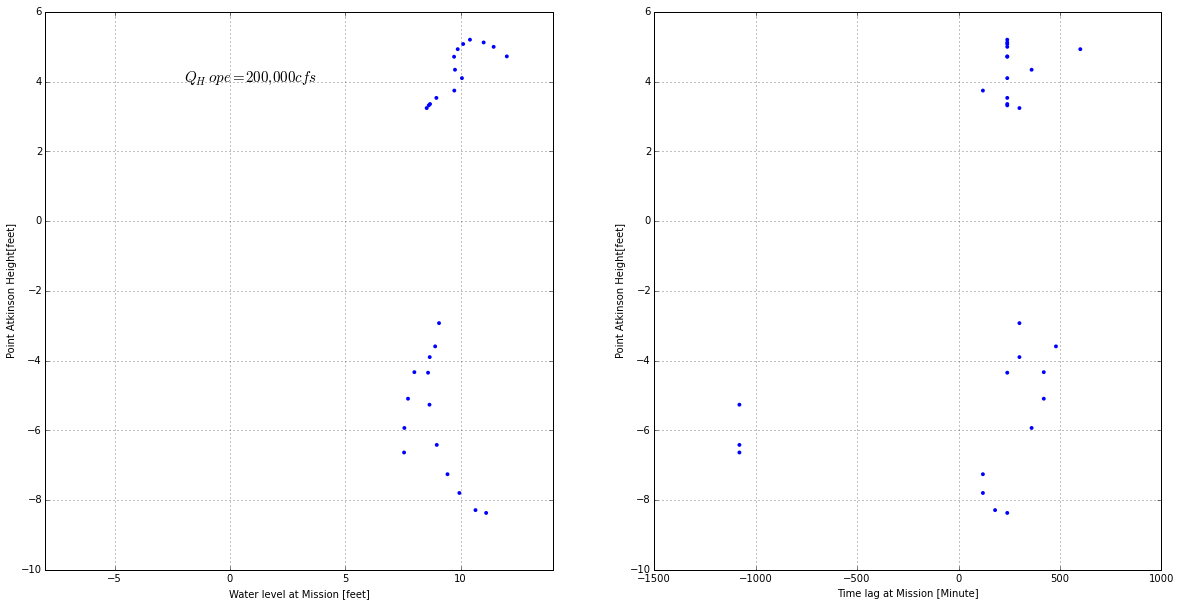

In [35]:
fig = plot_height_time_stn(ssh_obs_EC, ssh_obs, time_lag_obs, 'Mission')

* Amplitude of tidal height at Mission in the model is around 1 feet(0.3048m) higher than obs from EC.which means Mission is a little bit near the mouth. Two options I think about so far:
* 1 If 0.3048m does not count much in tidal progression to affect surface current direction, that's fine.
* 2 If counts, need to widen river channel in the north channel directly connected to edge of domain.

Deas Island

In [78]:
## grid cell for Deas Island is [414, 328]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 414, 328,ssh_mod, tt)

In [79]:
##combine both max and min water level for DEAS ISLAND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [80]:
df = print_out_diff_wl(mima, mimi)

In [81]:
df

[4.4068917045443072,
 4.626988015306277,
 4.753810976903269,
 4.7962327446211663,
 4.6230384253767216,
 4.4526509803736927,
 4.3374880796342383,
 4.096003127066794,
 3.7172483646963523,
 3.3150736506529679,
 3.5573424786094607,
 3.7186714060350354,
 3.8103653690007722,
 3.9771313625057845]

In [82]:
## average, max and min of the tidal amplitude at Deas Island channel for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 1.462
Min amplitude of model: 1.01
Mean amplitude of model: 1.267


In [54]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [55]:
##combine both time lag for high and low water level at Deas Island
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

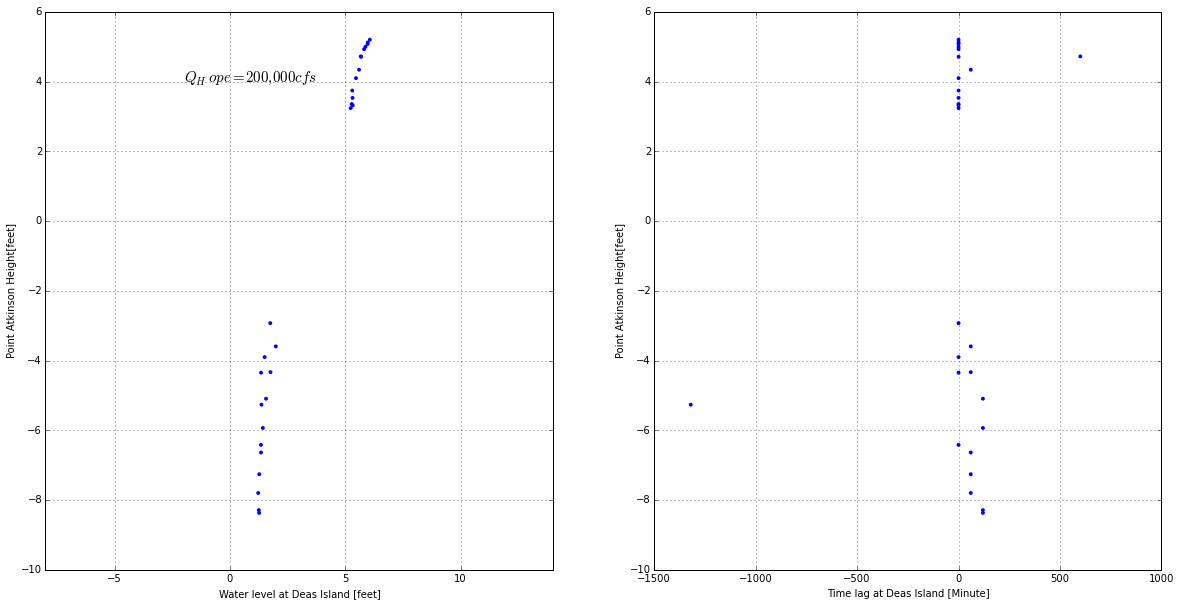

In [56]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Deas Island')

*  Compare with EC data below.

In [36]:
obs = pd.read_excel('08MH053_HRLY_2015.xls', skiprows = 0)

In [38]:
tt, wl_zoom = zoomin_tide_EC(obs)

In [39]:
obs_max, obs_min, t_max, t_min = find_highlow_tide_EC(tt, wl_zoom)

In [40]:
##combine both max and min water level for Deas Island with EC obs
ssh_obs_EC = []
ssh_obs_EC.append(obs_max)
ssh_obs_EC.append(obs_min)

In [41]:
df = print_out_diff_wl(obs_max, obs_min)

In [42]:
df

[9.849081364829395,
 9.85236220472441,
 9.93766404199475,
 9.996719160104988,
 9.53740157480315,
 9.048556430446194,
 8.585958005249344,
 7.860892388451443,
 6.456692913385826,
 6.062992125984252,
 6.850393700787402,
 7.696850393700787,
 7.9560367454068235,
 8.868110236220472]

In [43]:
## average, max and min of the tidal amplitude at Deas Island for observation
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of observation: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of observation: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of observation: {0:.4}'.format(mean_ddf_DI))

Max amplitude of observation: 3.047
Min amplitude of observation: 1.848
Mean amplitude of observation: 2.581


In [44]:
delta_max_obs, delta_min_obs = get_time_lag(t_min, time_min, t_max, time_max)

In [45]:
##combine both time lag for high and low water level at Deas Island with EC obs
time_lag_obs = []
time_lag_obs.append(delta_max_obs)
time_lag_obs.append(delta_min_obs)

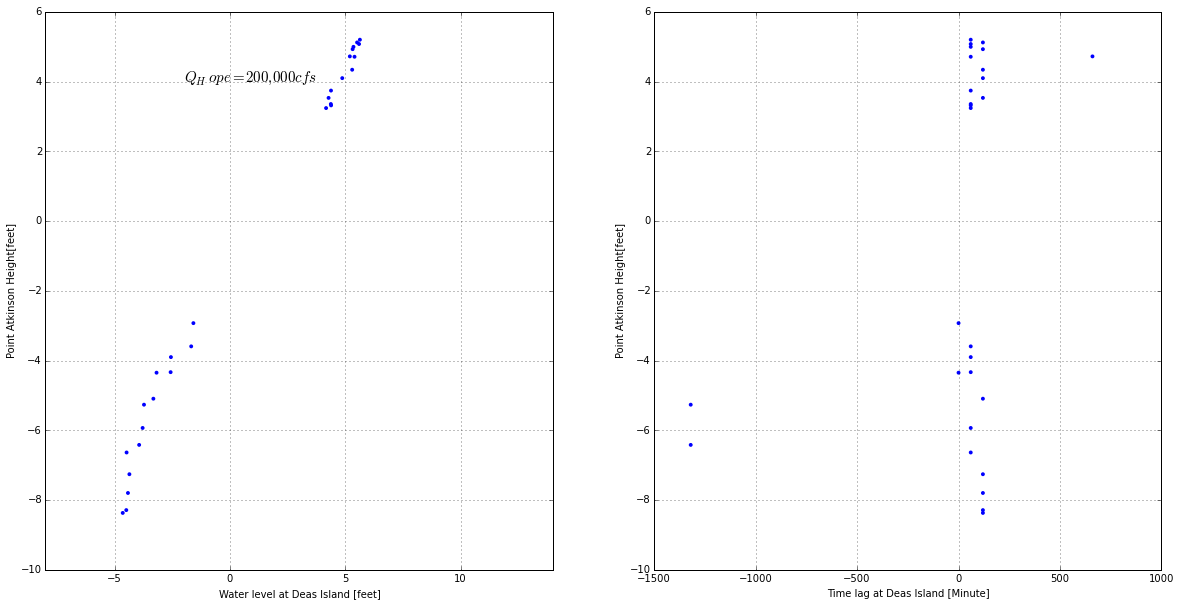

In [46]:
fig = plot_height_time_stn(ssh_obs_EC, ssh_obs, time_lag_obs, 'Deas Island')

*  Prediction of water level for Deas Island is 3-5 feet(1-1.5m) lower than obs from EC. Tide dissipate too fast at the beginning of river channel?

Sandheads

In [67]:
## grid cell for Sandheads is [426, 293]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 426, 293,ssh_mod, tt)

In [68]:
##combine both max and min water level for SANDHEADS
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [69]:
df = print_out_diff_wl(mima, mimi)

In [71]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [72]:
##combine both time lag for high and low water level at Sandheads
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

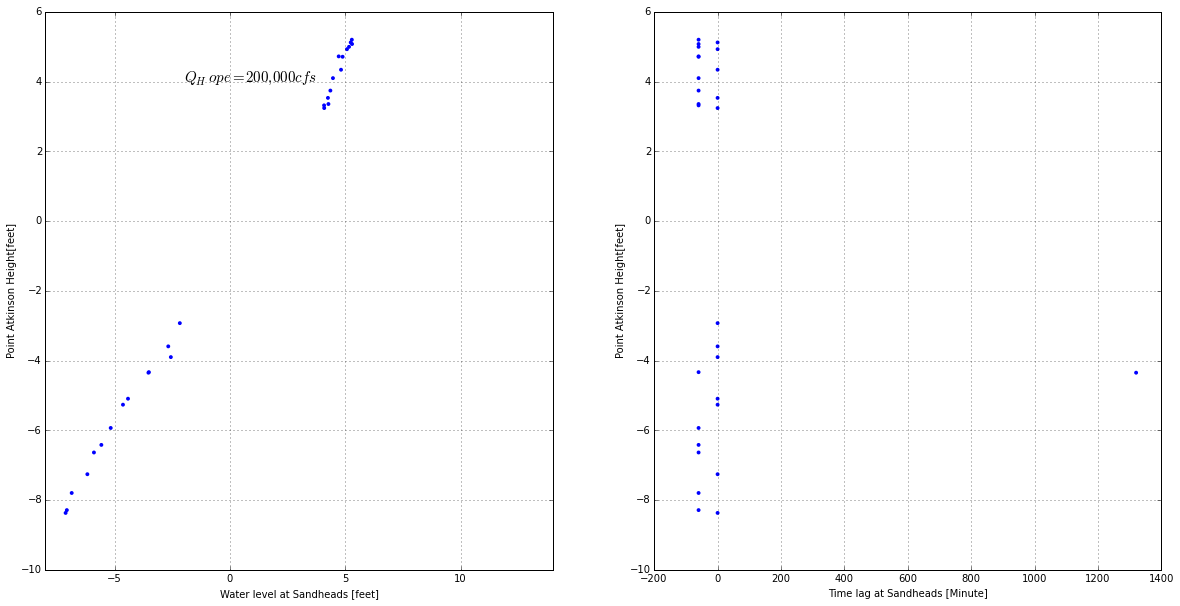

In [73]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Sandheads')

* Compared with Ages model at Steveston, too high water level for both ebb tide and flood tide.
* No data of Sandheads from EC available
* Turn to look at Steveston which could reflect tide in Sandheads, I think, as they are realy close.

Steveston Jetty

In [91]:
## grid cell for Steveston Jetty is [428, 292]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 428, 292,ssh_mod, tt)

In [92]:
##combine both max and min water level for Steveston Jetty
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [93]:
df = print_out_diff_wl(mima, mimi)

In [94]:
df

[11.853204937431755,
 12.231477758702955,
 12.099758533668016,
 11.486344606544714,
 10.885306465344165,
 9.7337451193902105,
 8.4353345898505587,
 7.3915983982912188,
 6.650641286779889,
 7.032914150731143,
 7.7783287040830595,
 8.7124281355089401,
 9.2681741777054576,
 9.979665905158976]

In [95]:
## average, max and min of the tidal amplitude at Steveston for model
ddf = np.array(df)
mean_ddf_ST = np.mean(ddf)* 0.3048
max_ddf_ST = np.max(ddf)* 0.3048
min_ddf_ST = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_ST))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_ST))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_ST))

Max amplitude of model: 3.728
Min amplitude of model: 2.027
Mean amplitude of model: 2.907


In [81]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [82]:
##combine both time lag for high and low water level at Sandheads
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

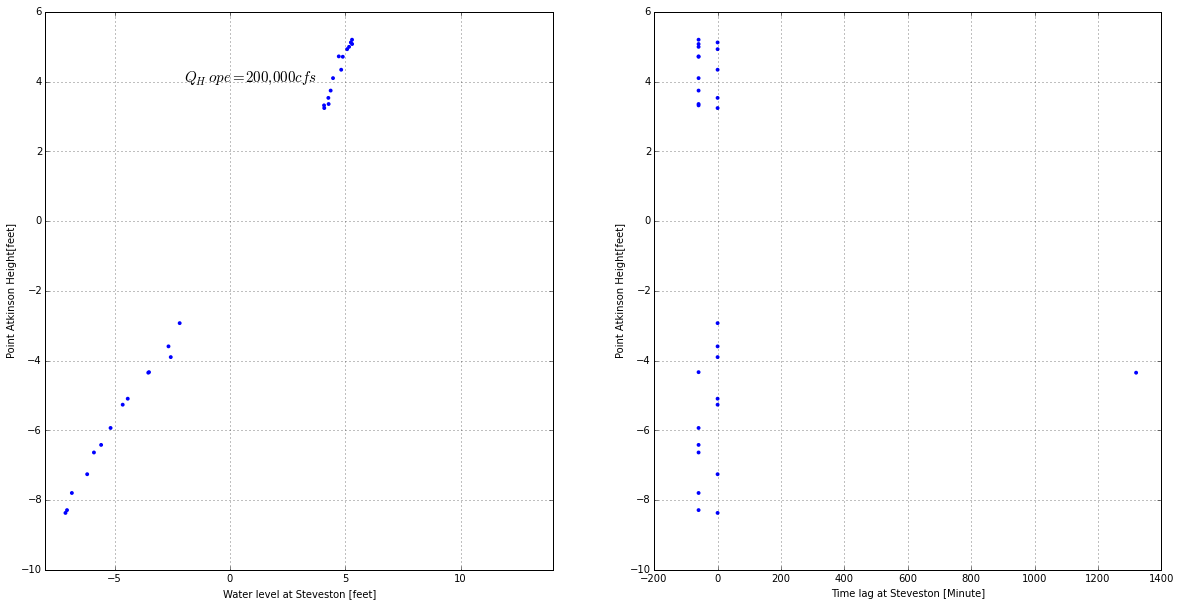

In [84]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Steveston')

* Compare with EC at Steveston below:

In [47]:
obs = pd.read_excel('08MH028_HRLY_2015.xls', skiprows = 0)

In [49]:
tt, wl_zoom = zoomin_tide_EC(obs)

In [50]:
obs_max, obs_min, t_max, t_min = find_highlow_tide_EC(tt, wl_zoom)

In [51]:
##combine both max and min water level for Deas Island with EC obs
ssh_obs_EC = []
ssh_obs_EC.append(obs_max)
ssh_obs_EC.append(obs_min)

In [52]:
df = print_out_diff_wl(obs_max, obs_min)

In [53]:
df

[11.309055118110237,
 11.453412073490814,
 11.459973753280838,
 11.249999999999998,
 10.590551181102363,
 10.095144356955378,
 9.41272965879265,
 8.372703412073491,
 7.103018372703412,
 6.87992125984252,
 7.513123359580053,
 8.29068241469816,
 8.884514435695538,
 9.49803149606299]

In [54]:
## average, max and min of the tidal amplitude at Steveston for observation
ddf = np.array(df)
mean_ddf_ST = np.mean(ddf)* 0.3048
max_ddf_ST = np.max(ddf)* 0.3048
min_ddf_ST = np.min(ddf)* 0.3048
print ('Max amplitude of observation: {0:.4}'.format(max_ddf_ST))
print ('Min amplitude of observation: {0:.4}'.format(min_ddf_ST))
print ('Mean amplitude of observation: {0:.4}'.format(mean_ddf_ST))

Max amplitude of observation: 3.493
Min amplitude of observation: 2.097
Mean amplitude of observation: 2.876


In [55]:
delta_max_obs, delta_min_obs = get_time_lag(t_min, time_min, t_max, time_max)

In [56]:
##combine both time lag for high and low water level at Deas Island with EC obs
time_lag_obs = []
time_lag_obs.append(delta_max_obs)
time_lag_obs.append(delta_min_obs)

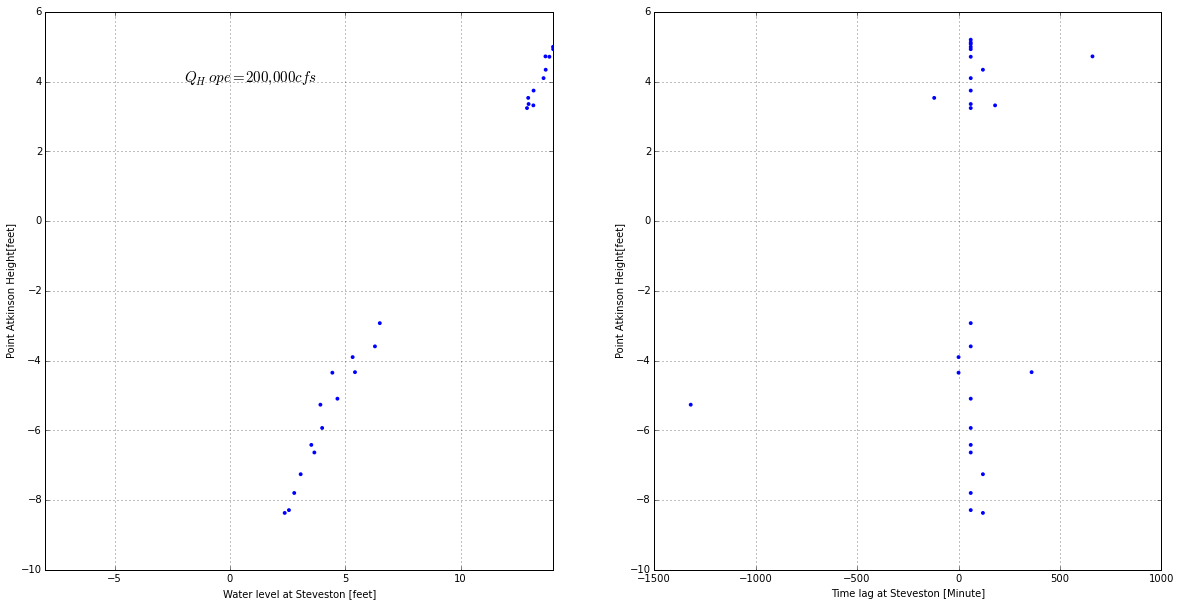

In [57]:
fig = plot_height_time_stn(ssh_obs_EC, ssh_obs, time_lag_obs, 'Steveston')

* Tidal amplitude difference between model result and obs from EC is not prominent, but still model is around 0.4-1 feet(0.1-0.3m) higher than obs, i guess this may be caused by 13km location difference, that is, our jetty location is 13km further to the strait than obs, so tidal amplitude is larger, I assume.

* In summary, compared with Ages graph and data from EC, amplitude of New West is 0.5m lower, further to mouth, Mission is 0.3m higher, close to mouth?  Deas Island is 1-1.5m lower, maybe tide propagate too fast at beginning of river channel. Steveston is good, I think. 
* For New Westminster, tide dissipates too much, which means tide feels difficult to propagate in my narrow and shallow river channel, if I reserve the length, I should deepen the depth for original river channel which I did not change mostly.
* As for Deas Island, this is part of original river channel, it dissipates fast, deepen depth or widen width could of original river channel helps.
* For Mission:
1 If the 0.3m high water level caused by tide: depth of Mission too deep? Need to decrease depth? 
2 Ages paper suggested Mission may not be affected by tide during freshet(Qhope = 300,000 cfs), so that 0.3m high water level may also caused by river discharge. Is that the river discharge source is only one grid cell with 3m depth that is too concentrated? So either deepen the depth of source or widen the source point should be considered.
